# **Análisis Exploratorio de los Datos**

Nuestra base de datos proviene de la fuente Binance y cuenta con registros diarios desde el año 2018 hasta el año 2025.

## **Librerías**

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera
from IPython.display import display, HTML
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

## **Sobre la base de datos**

In [2]:
BASE_DIR = os.getcwd()  # si estás en notebooks
data_path = os.path.join(BASE_DIR, '..', 'data', 'btc_1d_data_2018_to_2025.csv')
btc = pd.read_csv(data_path)
btc

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844,2018-01-01 23:59:59.999,1.147997e+08,105595,3961.938946,5.280975e+07,0
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,1.580801e+08,0
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,2018-01-03 23:59:59.999,2.361169e+08,162787,8994.953566,1.335873e+08,0
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,2018-01-04 23:59:59.999,3.127816e+08,170310,12680.812951,1.861168e+08,0
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,2.118299e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2589,2025-02-02,100635.66,101456.60,99747.59,99796.00,3149.622330,2025-02-02 23:59:59.999,3.167280e+08,558753,1223.084700,1.231618e+08,0
2590,2025-02-03,97700.59,97782.79,91231.00,94495.21,20992.955720,2025-02-03 23:59:59.999,1.983835e+09,2309956,9239.171560,8.738586e+08,0
2591,2025-02-04,101328.51,101660.94,100743.33,101367.77,1910.355420,2025-02-04 23:59:59.999,1.933988e+08,208849,822.417140,8.326802e+07,0
2592,2025-02-05,97763.14,98930.44,97131.43,97589.30,8160.567950,2025-02-05 23:59:59.999,7.990502e+08,1597813,3672.410530,3.596230e+08,0


El conjunto de datos inicial contiene **2594** observaciones diarias del precio de Bitcoin (BTC), **abarcando el periodo desde el 1 de enero de 2018 hasta el 6 de febrero de 2025**. Cada registro incluye **12** características que describen la actividad del mercado en el formato estándar **OHLCV (Open, High, Low, Close, Volume)**, junto con otras de interés. De acuerdo con el objetivo del proyecto, que es predecir el comportamiento futuro basándose exclusivamente en su histórico temporal, se seleccionarán únicamente dos columnas: ``la fecha del registro (Open time) y el precio de cierre (Close)``.

In [3]:
databtc = btc.copy()
databtc = databtc[['Open time', 'Close']].dropna().reset_index(drop=True)
databtc['Close'] = databtc['Close'].astype(float)
databtc['Open time'] = pd.to_datetime(databtc['Open time'])
databtc = databtc.rename(columns={'Open time': 'Fecha', 'Close': 'Precio'})
databtc = databtc.set_index('Fecha')

Ahora, ``databtc`` es nuestro conjunto de datos de interés para el análisis.

El siguiente paso es calcular los retornos logarítmicos. Esto a partir de la siguiente fórmula:

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

Donde:

* $r_t$ es el retorno logarítmico en el periodo t.

* $P_t$ es el precio del activo en el periodo t (precio de hoy).

* $P_{t-1}$ es el precio del activo en el periodo anterior t-1 (precio de ayer).

* $\ln$ es el logaritmo natural.

In [4]:
databtc['RetornoLog'] = np.log(databtc['Precio'] / databtc['Precio'].shift(1))
databtc.dropna(inplace=True)
databtc

,Precio,RetornoLog
Fecha,,
2018-01-02,14675.11,0.092392
2018-01-03,14919.51,0.016517
2018-01-04,15059.54,0.009342
2018-01-05,16960.39,0.118869
2018-01-06,17069.79,0.006430
...,...,...
2025-02-02,99796.00,-0.024038
2025-02-03,94495.21,-0.054579
2025-02-04,101367.77,0.070206


Finalmente nos quedamos con la base de datos resultante luego de la transformación y preprocesamiento aplicado.

## **Sobre las variables**

### **Precio**

#### **Estadísticas descriptivas**

In [5]:
databtc['Precio'].describe()

count      2593.000000
mean      29096.252140
std       23578.757068
min        3211.720000
25%        9068.650000
50%       22762.520000
75%       43538.040000
max      106143.820000
Name: Precio, dtype: float64

A partir de las estadísticas descriptivas de la variable ``Precio``, se pueden identificar distintas características sobre su comportamiento. En primer lugar, se observa que la media (**29096.25 USD**) es superior a la mediana (**22762.52 USD**), lo que indica la existencia de una asimetría positiva, es decir, sesgo a la derecha en la distribución de los datos. Asimismo, el alto valor de la desviación estándar (**23578.75 USD**) da indicios de una considerable dispersión presente, lo cual podemos evidenciar igualmente en la diferencia de valores entre los extremos (**3211.72 USD** y **106143.82 USD**) y los cuartiles.

#### **Distribución de los datos**

In [6]:
jb_stat_precio, jb_p_precio = jarque_bera(databtc['Precio'])

print(f"Estadístico JB: {jb_stat_precio:.3f}")
print(f"P-valor: {jb_p_precio:.4e}")

alpha = 0.05
if jb_p_precio < alpha:
    print("La serie NO sigue una distribución normal.")
else:
    print("La serie podría seguir una distribución normal.")

Estadístico JB: 493.376
P-valor: 7.3229e-108
La serie NO sigue una distribución normal.


In [7]:
skew_precio = databtc['Precio'].skew()
print(f"Asimetría (Skewness): {skew_precio:.4f}")

Asimetría (Skewness): 1.0394


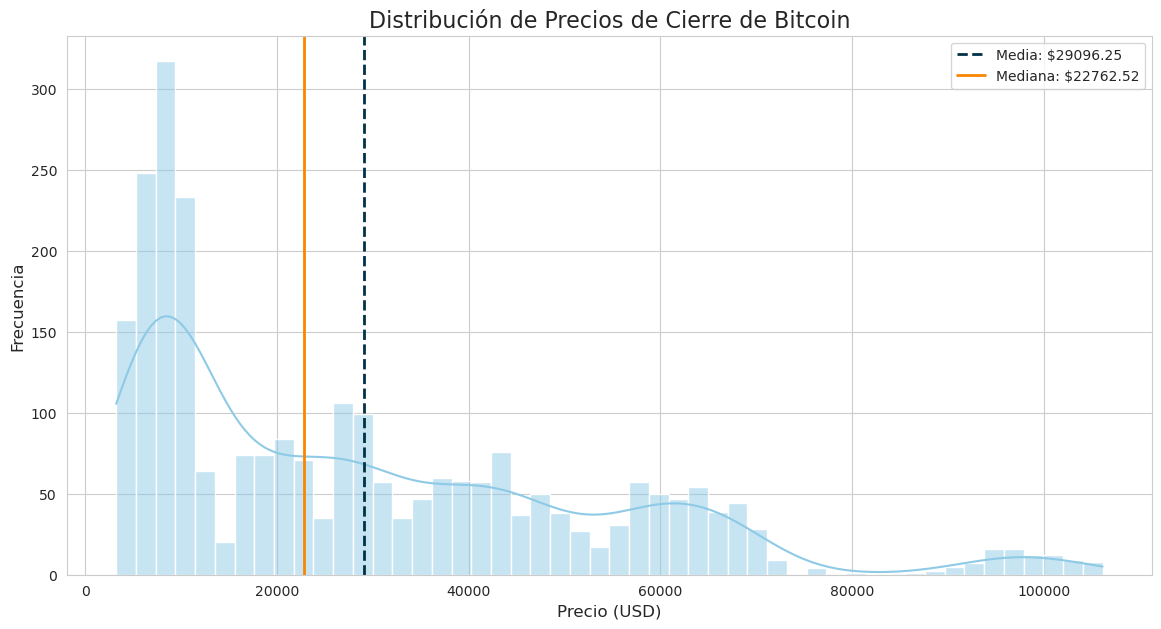

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

sns.histplot(data=databtc, x='Precio', kde=True, bins=50, color='#8ecae6')

plt.axvline(databtc['Precio'].mean(), color='#023047', linestyle='--', linewidth=2, label=f'Media: ${databtc["Precio"].mean():.2f}')
plt.axvline(databtc['Precio'].median(), color='#fb8500', linestyle='-', linewidth=2, label=f'Mediana: ${databtc["Precio"].median():.2f}')

plt.title('Distribución de Precios de Cierre de Bitcoin', fontsize=16)
plt.xlabel('Precio (USD)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.show()

En el test de normalidad, se rechazó la hipótesis nula, es decir, que los datos no siguen una distribución normal. Asimismo, el estadístico de asimetría (``Skewness``) dio como resultado **1.0394**, lo que confirma una marcada asimetría positiva en la distribución de los precios. Este resultado numérico es consistente con el histograma, donde se observa una clara cola extendida hacia la derecha.

#### **Picos**

In [9]:
fecha_max_precio = databtc['Precio'].idxmax()
fecha_min_precio = databtc['Precio'].idxmin()

max_precio = databtc.loc[fecha_max_precio, 'Precio']
min_precio = databtc.loc[fecha_min_precio, 'Precio']

print(f" El precio máximo fue de {max_precio:.2f} USD y se obtuvo en la fecha {fecha_max_precio.date()}.")
print(f" El precio mínimo fue de {min_precio:.2f} USD y se obtuvo eb la fecha {fecha_min_precio.date()}.")

 El precio máximo fue de 106143.82 USD y se obtuvo en la fecha 2025-01-21.
 El precio mínimo fue de 3211.72 USD y se obtuvo eb la fecha 2018-12-15.


#### **Serie temporal**

In [10]:
adftest = adfuller(databtc['Precio'].dropna())
p_value = adftest[1]

print(f" Estadístico ADF: {adftest[0]:.4f}")
print(f" p-value: {p_value:.4f}")

if p_value <= 0.05:
    print("La serie es ESTACIONARIA (p-value <= 0.05)")
else:
    print(" La serie NO es ESTACIONARIA (p-value > 0.05)")

 Estadístico ADF: -0.0545
 p-value: 0.9538
 La serie NO es ESTACIONARIA (p-value > 0.05)


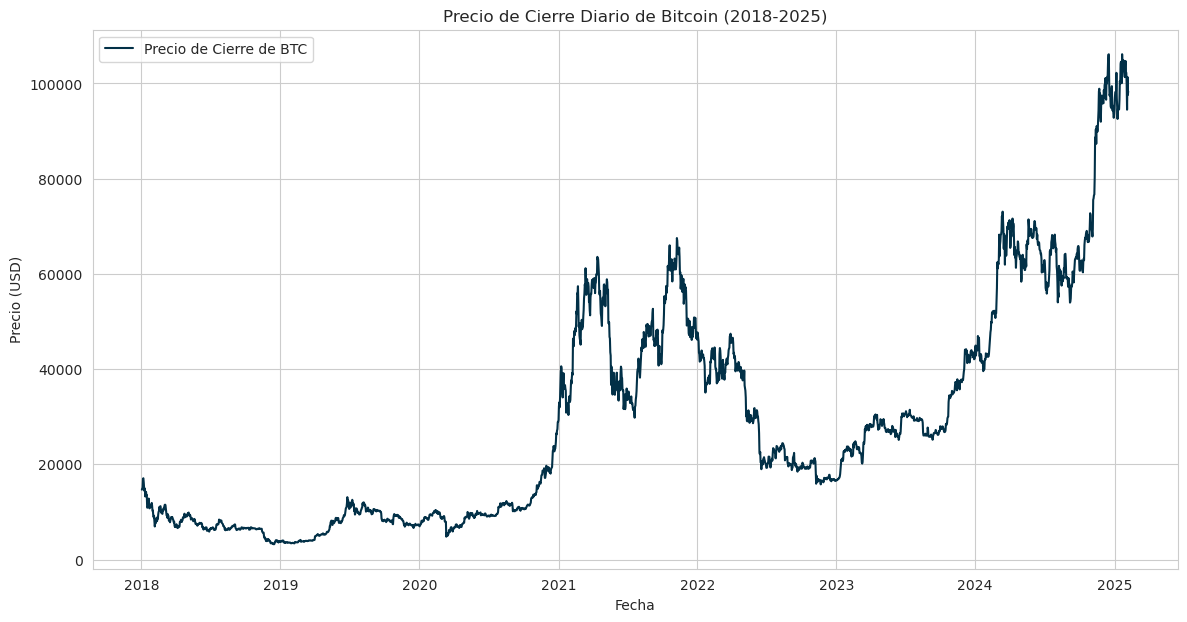

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(databtc['Precio'], label='Precio de Cierre de BTC', color ='#023047' )
plt.title('Precio de Cierre Diario de Bitcoin (2018-2025)')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

La serie temporal del precio de cierre de Bitcoin confirma lo mostrado por la prueba de Dickey-Fuller: la serie es **no estacionaria**.

Entre 2018 y finales de 2020 el precio se mantuvo relativamente estable, con subidas y caídas que no fueron tan marcadas. En 2021 se dio una gran subida, aunque hacia la mitad del mismo año ocurrió una fuerte caída, de la cual el precio logró recuperarse poco después. Durante 2022 se presentó una caída constante que se prolongó hasta 2023. Desde entonces, se observa una tendencia de crecimiento sostenido que llega hasta el año 2025.

### **Retornos logarítmicos**

#### **Estadísticas descriptivas**

In [12]:
databtc['RetornoLog'].describe()

count    2593.000000
mean        0.000769
std         0.036221
min        -0.502607
25%        -0.014171
50%         0.000708
75%         0.016304
max         0.178449
Name: RetornoLog, dtype: float64

Al analizar las estadísticas de los retornos logarítmicos se observa que tanto la media (**0.0006**) como la mediana (**0.0007**) son prácticamente cero, lo que indica que la serie se comporta de manera estacionaria. Por otro lado, la desviación estándar muestra que los retornos presentan una variación típica de **3.62%** por día. Finalmente, los valores mínimo (**-0.50**) y máximo (**0.17**) evidencian que, si bien la mayor parte de los datos se concentra en torno a ese comportamiento estable, existen días con fluctuaciones mucho más pronunciadas.

#### **Distribución de los datos**

In [13]:
jb_stat_retornos, jb_p_retornos = jarque_bera(databtc['RetornoLog'])

print(f"Estadístico JB: {jb_stat_retornos:.3f}")
print(f"P-valor: {jb_p_retornos:.4e}")

alpha = 0.05
if jb_p_retornos < alpha:
    print("La serie NO sigue una distribución normal.")
else:
    print("La serie podría seguir una distribución normal.")

Estadístico JB: 31862.647
P-valor: 0.0000e+00
La serie NO sigue una distribución normal.


In [14]:
skew_retlog = databtc['RetornoLog'].skew()
print(f"Asimetría (Skewness): {skew_retlog:.4f}")

Asimetría (Skewness): -1.1582


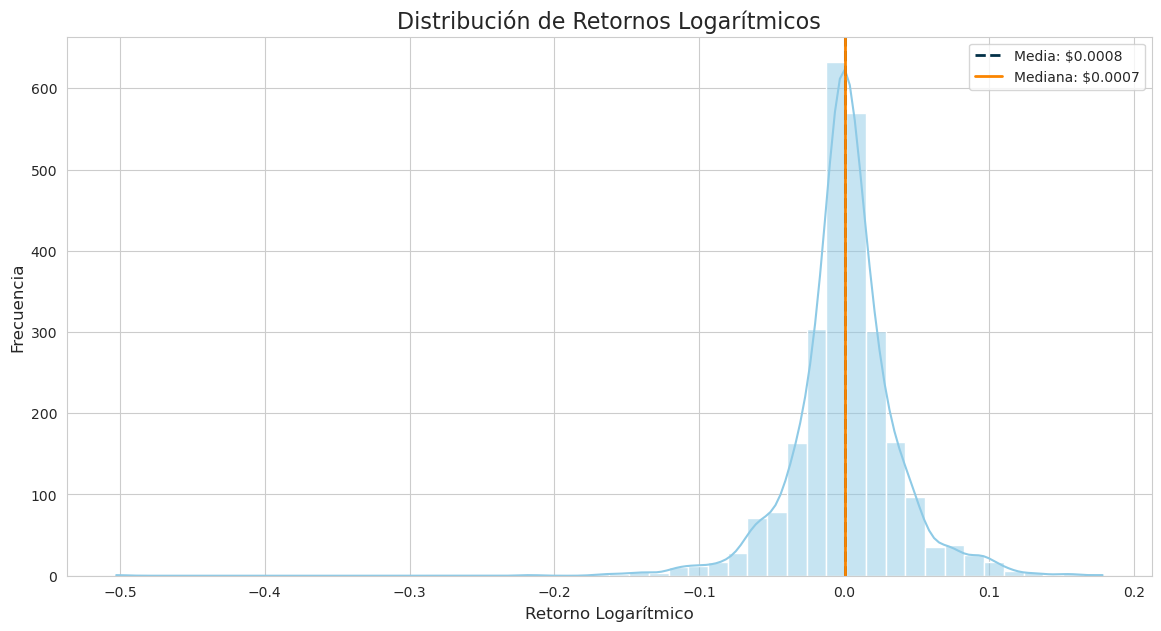

In [15]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

sns.histplot(data=databtc, x='RetornoLog', kde=True, bins=50, color='#8ecae6')

plt.axvline(databtc['RetornoLog'].mean(), color='#023047', linestyle='--', linewidth=2, label=f'Media: ${databtc["RetornoLog"].mean():.4f}')
plt.axvline(databtc['RetornoLog'].median(), color='#fb8500', linestyle='-', linewidth=2, label=f'Mediana: ${databtc["RetornoLog"].median():.4f}')

plt.title('Distribución de Retornos Logarítmicos', fontsize=16)
plt.xlabel('Retorno Logarítmico', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.show()

En el test de normalidad, se rechazó la hipótesis nula, es decir, que los datos no siguen una distribución normal. Asimismo, el estadístico de asimetría (``Skewness``) dio como resultado **-1.1582**, lo que confirma una marcada asimetría negativa en la distribución de los retornos logarítmicos. Este resultado numérico es consistente con el histograma, donde se observa una clara cola extendida hacia la izquierda.

#### **Picos**

In [16]:
peor_dia = databtc['RetornoLog'].idxmin()
mejor_dia = databtc['RetornoLog'].idxmax()

peor_retorno = databtc.loc[peor_dia, 'RetornoLog']
mejor_retorno = databtc.loc[mejor_dia, 'RetornoLog']

print(f" El día en el que se obtuvo la mayor caída fue {peor_dia.date()} con un retorno de {peor_retorno:.2%}.")
print(f" El día en el que se obtuvo la mayor subida fue {mejor_dia.date()} con un retorno de {mejor_retorno:.2%}.")

 El día en el que se obtuvo la mayor caída fue 2020-03-12 con un retorno de -50.26%.
 El día en el que se obtuvo la mayor subida fue 2021-02-08 con un retorno de 17.84%.


#### **Serie temporal**

In [17]:
adftest = adfuller(databtc['RetornoLog'].dropna())
p_value = adftest[1]

print(f" Estadístico ADF: {adftest[0]:.4f}")
print(f" p-value: {p_value:.4f}")

if p_value <= 0.05:
    print("La serie es ESTACIONARIA (p-value <= 0.05)")
else:
    print(" La serie NO es ESTACIONARIA (p-value > 0.05)")

 Estadístico ADF: -35.5112
 p-value: 0.0000
La serie es ESTACIONARIA (p-value <= 0.05)


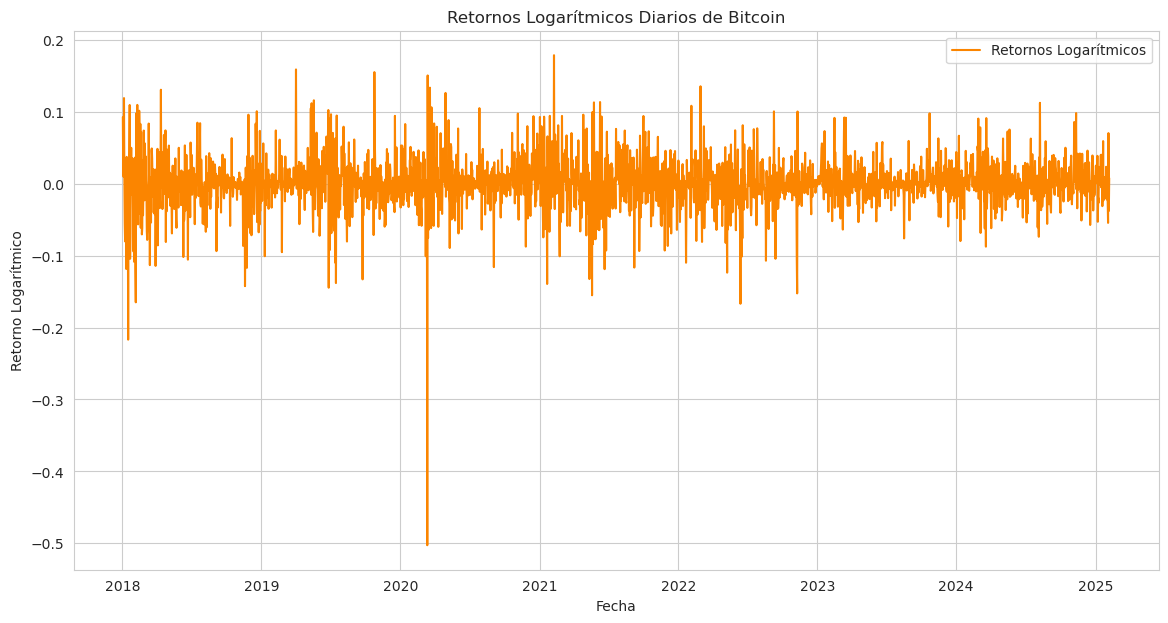

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(databtc['RetornoLog'], label='Retornos Logarítmicos', color='#fb8500')
plt.title('Retornos Logarítmicos Diarios de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Retorno Logarítmico')
plt.legend()
plt.grid(True)
plt.show()

Al observar el gráfico de los retornos logarítmicos, se nota que los valores fluctúan alrededor de cero, lo que confirma que la serie es estacionaria, a diferencia del comportamiento que mostraban los precios.

También se aprecia que la magnitud de las fluctuaciones diarias no es constante pues hay periodos con variaciones pequeñas y otros con cambios mucho más grandes, los cuales tienden a concentrarse en bloques de tiempo.

Finalmente, destaca un pico pronunciado a la baja, correspondiente a la caída del **-50.26%** registrada el 12 de marzo de 2020, evento que ya habíamos identificado previamente.

Una vez analizadas las propiedades básicas de la distribución de los retornos, el siguiente paso es estudiar la posible existencia de dependencia temporal. Para ello, se verificará si los retornos de un día están correlacionados con los de días anteriores, es decir, si existe autocorrelación. El análisis se realizará primero con una prueba estadística formal de independencia y luego su representación gráfica.

In [19]:
retornos = databtc['RetornoLog']
lagsprueba = [7, 14, 21, 28]

#### **Autocorrelación (ACF) de los retornos (RetornoLog)**

In [20]:
ljung_ret = acorr_ljungbox(retornos, lags=lagsprueba, return_df=True)

html_ljung_ret = ljung_ret.style.set_properties(**{'text-align': 'center', 'font-size': '12pt'}).format({'lb_pvalue': '{:.8e}'}).to_html()
display(HTML(html_ljung_ret))

,lb_stat,lb_pvalue
7,20.702615,4.23615402e-03
14,26.153238,2.47495660e-02
21,29.799477,9.60921646e-02
28,33.801536,2.07484002e-01


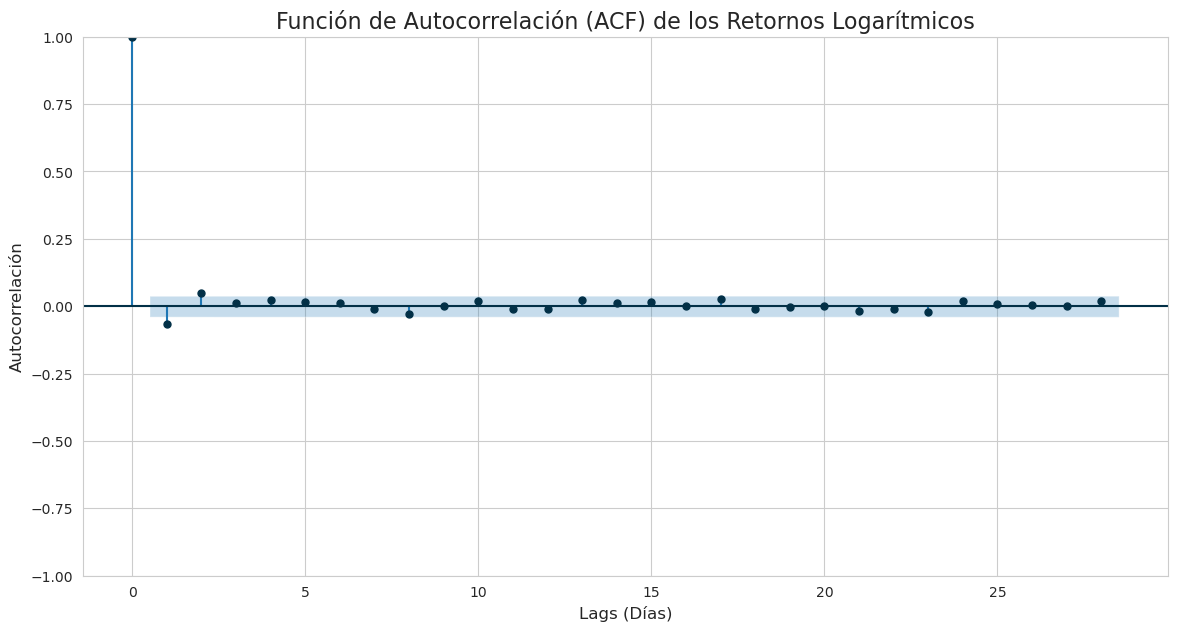

In [21]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_acf(retornos.dropna(), lags=28, ax=ax, color = '#023047')

ax.set_title('Función de Autocorrelación (ACF) de los Retornos Logarítmicos', fontsize=16)
ax.set_xlabel('Lags (Días)', fontsize=12)
ax.set_ylabel('Autocorrelación', fontsize=12)
ax.grid(True)

plt.show()

La prueba de Ljung–Box aplicada a los retornos originales muestra que existe cierta autocorrelación lineal estadísticamente significativa en los horizontes más cortos: para los rezagos de **7 y 14 días** se obtuvieron p-values de **0.0042 y 0.0247, respectivamente**. Sin embargo, esta dependencia es débil y desaparece en horizontes más largos, como lo reflejan los p-values no significativos en los rezagos de **21 (0.0961) y 28 días (0.2075)**. En conjunto, estos resultados permiten concluir que **no existe una autocorrelación lineal persistente en la serie de retornos**.

Esta conclusión también se observa en el gráfico de la ACF. Se observa que, si bien el lag 0 tiene un valor de 1 (la correlación perfecta de la serie consigo misma), a partir del lag 1 casi todos los coeficientes se mantienen dentro del intervalo de confianza representado por la sombra azul y muy cercanos a cero. Esto evidencia que que los retornos pasados no son predictores lineales de los retornos futuros.

#### **Autocorrelación (ACF) de los cuadrados de los retornos (RetornoLog)**

In [22]:
ljung_ret2 = acorr_ljungbox(retornos**2, lags=lagsprueba, return_df=True)
html_ljung_ret2 = ljung_ret2.style.set_properties(**{'text-align': 'center', 'font-size': '12pt'}).format({'lb_pvalue': '{:.8e}'}).to_html()
display(HTML(html_ljung_ret2))

,lb_stat,lb_pvalue
7,48.819700,2.46116825e-08
14,58.348361,2.28080011e-07
21,67.151084,9.98336894e-07
28,70.046971,1.83309950e-05


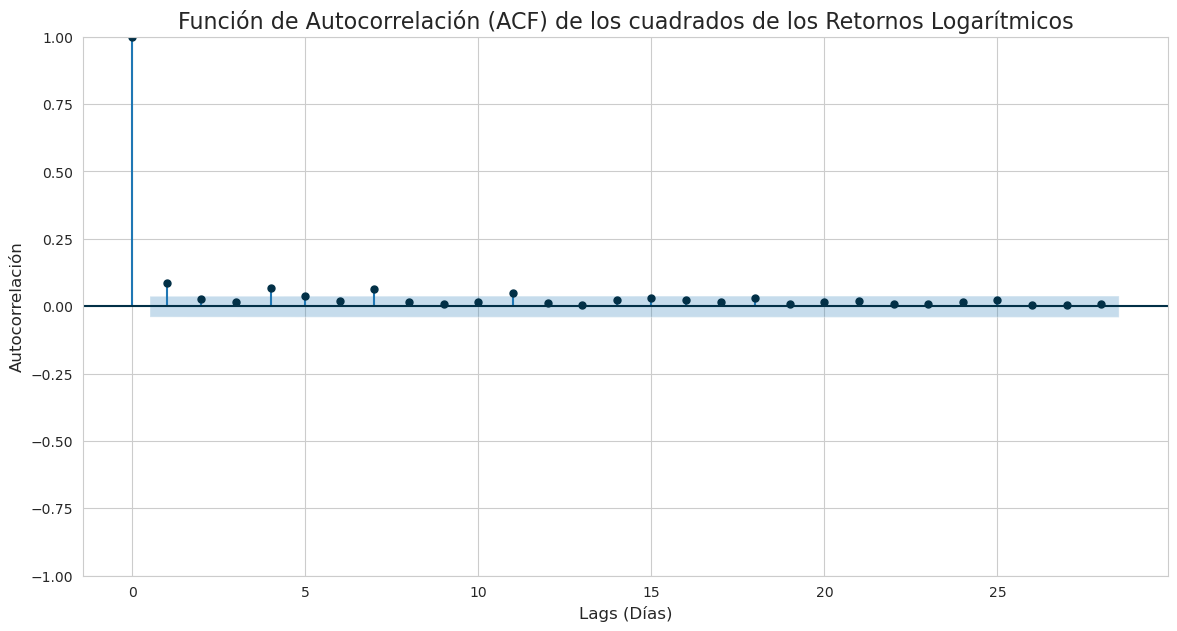

In [23]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_acf((retornos**2).dropna(), lags=28, ax=ax, color = '#023047')

ax.set_title('Función de Autocorrelación (ACF) de los cuadrados de los Retornos Logarítmicos', fontsize=16)
ax.set_xlabel('Lags (Días)', fontsize=12)
ax.set_ylabel('Autocorrelación', fontsize=12)
ax.grid(True)

plt.show()

Los resultados de la prueba de Ljung–Box sobre los retornos al cuadrado muestran que, para los lags de 7, 14, 21 y 28 días, los p-values son prácticamente cero. Esto indica que se puede rechazar la hipótesis nula y concluir que existe autocorrelación significativa en la magnitud de los movimientos de la serie. En otras palabras, aunque los retornos en sí no presenten dependencia lineal, la variabilidad de esos retornos (``volatilidad``) sí muestra un patrón claro. Esta conclusión también se confirma en el gráfico de la ACF, donde hay puntos que aparecen fuera del intervalo de confianza representado por la sombra azul.

## **Preprocesamiento y cálculo de features**

### **Cálculo de retornos logarítmicos**

Este cálculo ya se presentó en la sección anterior y se realizó a partir de la variable ``Precio``. Su propósito fue disponer de los retornos logarítmicos necesarios para llevar a cabo los análisis pertinentes.

### **Cálculo de la volatilidad histórica (variable objetivo)**

La **volatilidad** es una medida de **dispersión de los rendimientos** de un activo financiero.

Para una ventana de tamaño *n*:

$$
\sigma_t = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( r_{t-i} - \bar{r} \right)^2 }, 
\quad \text{donde} \quad 
r_t = \ln \left( \frac{P_t}{P_{t-1}} \right)
$$

Donde:

- $r_t$ es el retorno logarítmico diario.  
- $\sigma_t$ es la volatilidad histórica realizada en ventana de *n* días.  
- $\bar{r}$ es el promedio de los retornos en la ventana

In [24]:
ventanas = [7, 14, 21, 28]

for ventana in ventanas:
    col_name = f'Volatilidad_{ventana}d'
    databtc[col_name] = databtc['RetornoLog'].rolling(window=ventana).std() * np.sqrt(365)

volatilidad_cols = [f'Volatilidad_{v}d' for v in ventanas]      

Para calcular la volatilidad diaria, se utilizó la desviación estándar móvil de los retornos logarítmicos en cuatro ventanas de interés (**7, 14, 21 y 28 días**), trabajadas de manera individual. Luego, estos valores se anualizaron multiplicándolos por la raíz cuadrada de **365**. Este ajuste permite expresar la volatilidad en una escala anual, lo que facilita su comparación con otros activos y con distintos periodos de tiempo.

Esta medida se definió como la variable objetivo para el modelo de predicción de este proyecto.

En la tabla resultante se observa que cada ventana presenta valores faltantes al inicio. Esto sucede porque, por ejemplo, en la ventana de 7 días no se pueden calcular los primeros 7 retornos, en la de 14 días las primeras 14 observaciones, y así sucesivamente. Esto era esperado, ya que el cálculo de la desviación estándar móvil necesita acumular suficientes observaciones previas para poder hacerse. Por lo tanto, las primeras filas no tienen información suficiente y aparecen como nulas. Estos valores ausentes se tendrán en cuenta al momento de implementar los modelos, indicando desde qué observación debe comenzar cada ventana.

#### **Sobre la variable**

##### **Distribución de los datos**

In [25]:
jb_resultados = {}

for col in volatilidad_cols:
    jb_stat, jb_p_value = jarque_bera(databtc[col].dropna())
    jb_resultados[col] = {
        "Estadístico JB": jb_stat,
        "P-valor": jb_p_value
    }

jb_df = pd.DataFrame(jb_resultados).T

html_output_jb = jb_df.style.set_properties(**{'text-align': 'center', 'font-size': '12pt'}).to_html()
display(HTML(html_output_jb))

,Estadístico JB,P-valor
Volatilidad_7d,49386.533377,0.000000
Volatilidad_14d,24143.363794,0.000000
Volatilidad_21d,13931.461281,0.000000
Volatilidad_28d,9325.456928,0.000000


Luego de aplicar el test de Jarque Bera correspondiente al análisis de la distribución de los datos, obtuvimos como resultado que ninguna de las series correspondientes a cada ventana siguen una distribución normal.

In [26]:
skew_results = {}
for col in [f'Volatilidad_{v}d' for v in ventanas]:
    skew_results[col] = databtc[col].skew()

skew_df = pd.DataFrame(skew_results.items(), columns=['Variable', 'Asimetría (Skewness)'])

html_output = skew_df.style.set_properties(**{'text-align': 'center', 'font-size': '12pt'}).hide(axis="index").to_html()
display(HTML(html_output))

Variable,Asimetría (Skewness)
Volatilidad_7d,2.927654
Volatilidad_14d,2.567215
Volatilidad_21d,2.301968
Volatilidad_28d,2.141476


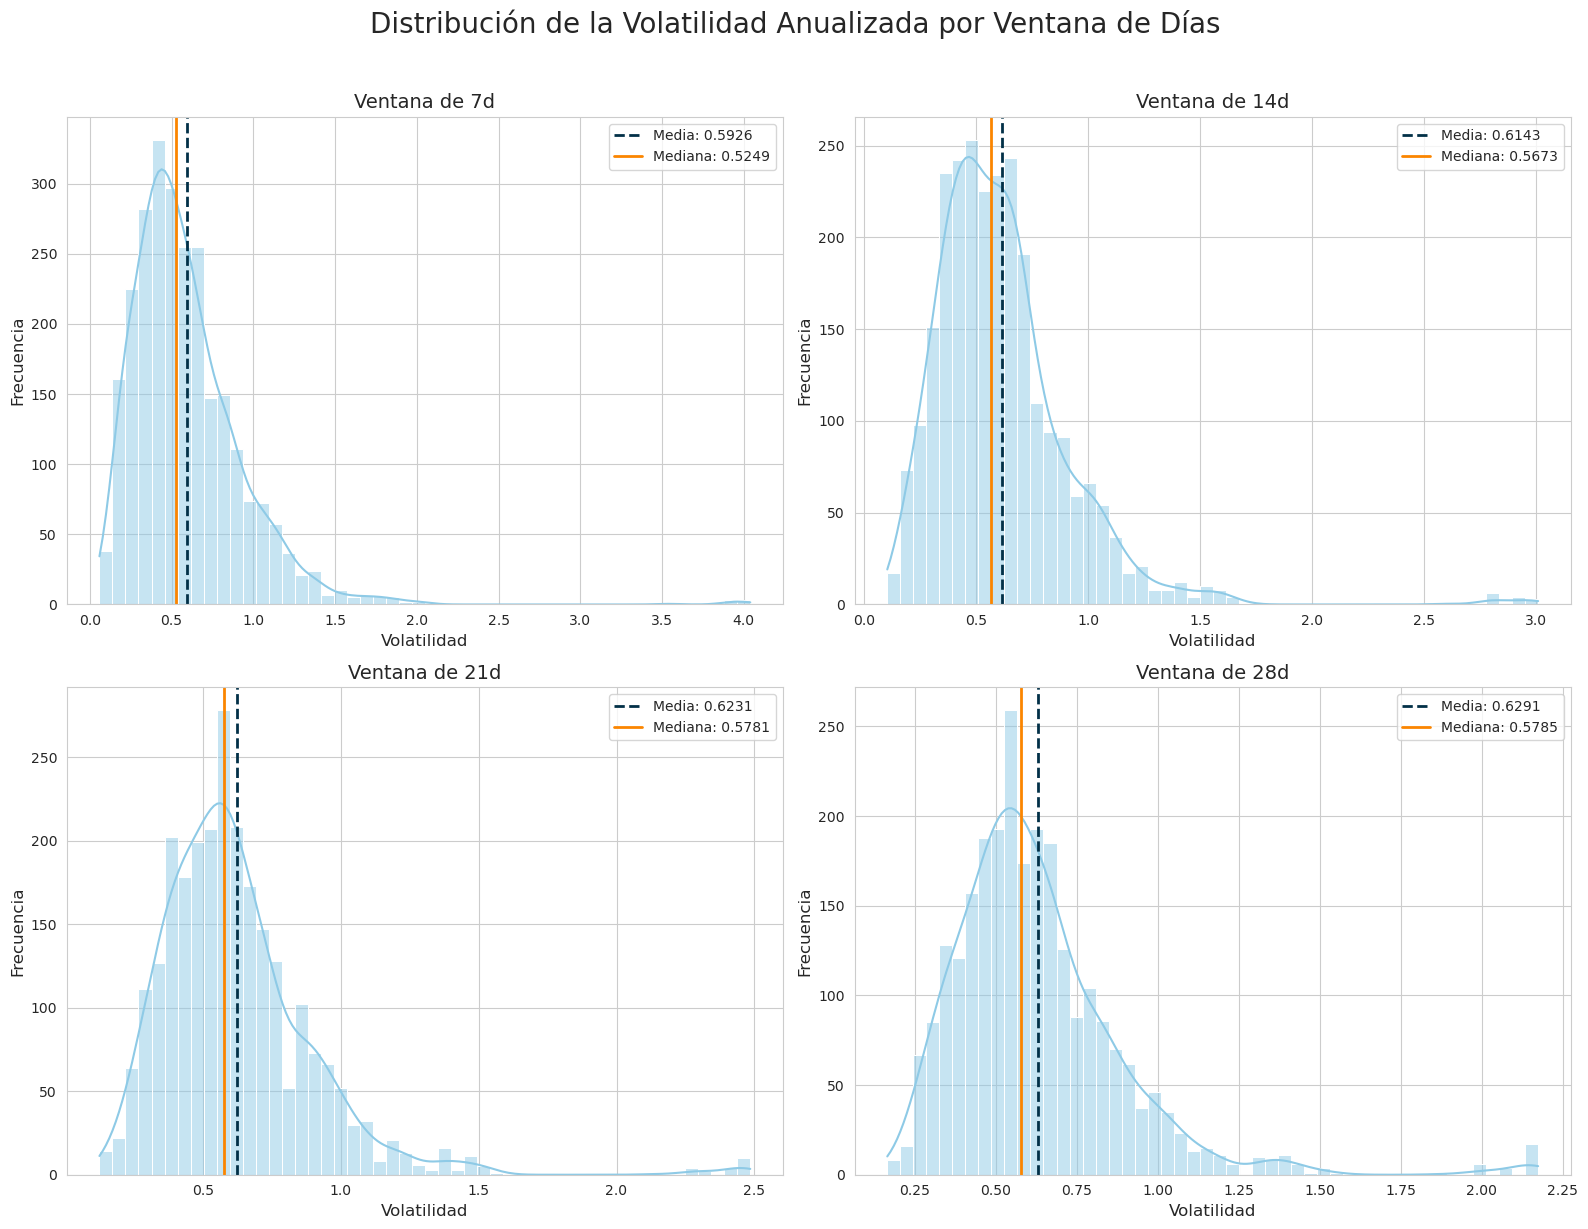

In [27]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

fig.suptitle('Distribución de la Volatilidad Anualizada por Ventana de Días', fontsize=20, y=1.02)

for ax, col in zip(axes.flatten(), volatilidad_cols):

    sns.histplot(data=databtc, x=col, kde=True, bins=50, color='#8ecae6', ax=ax)
    
    mean_val = databtc[col].mean()
    median_val = databtc[col].median()
    
    ax.axvline(mean_val, color='#023047', linestyle='--', linewidth=2, label=f'Media: {mean_val:.4f}')
    ax.axvline(median_val, color='#fb8500', linestyle='-', linewidth=2, label=f'Mediana: {median_val:.4f}')
    
    ax.set_title(f'Ventana de {col.split("_")[1]}', fontsize=14)
    ax.set_xlabel('Volatilidad', fontsize=12)
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.legend()
    
plt.tight_layout()
plt.show()

Para todas las ventanas temporales analizadas, se comprobó que ninguna serie sigue una distribución normal. Esto se complementa con el valor del test de asimetría donde se hallaron valores que van desde **3.05** en la ventana de 7 días hasta **2.14** en la de 28 días. Esta asimetría positiva muestra que la distribución de la volatilidad presenta una cola pesada hacia la derecha. Lo anterior se evidencia también en los histogramas graficados para cada ventana. Además, se observa una disminución progresiva a medida que aumenta la ventana, lo cual sugiere que los eventos extremos de alta volatilidad tienen mayor impacto en los plazos cortos, pero se suavizan al calcular promedios en horizontes más largos. 

##### **Volatilidades por ventanas**

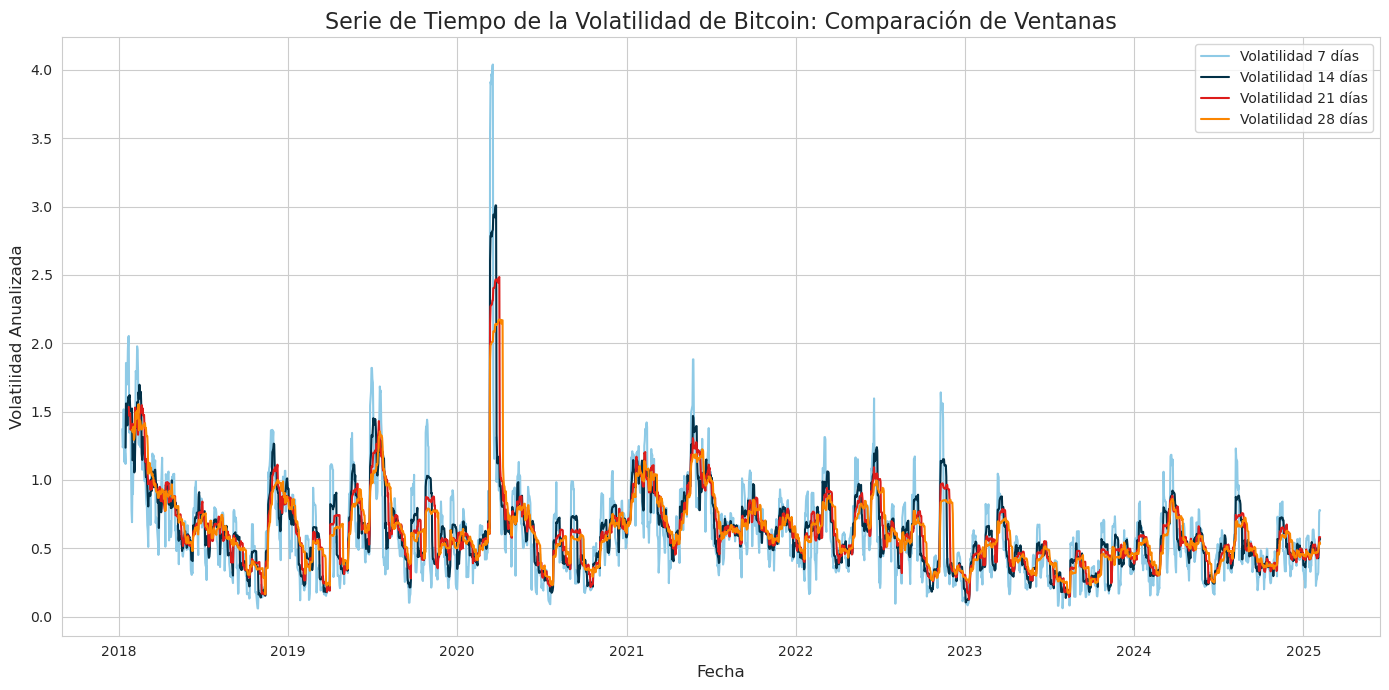

In [28]:
colors = ['#8ecae6', '#023047', '#dd1c1a', '#fb8500']

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

for i, col in enumerate(volatilidad_cols):
    plt.plot(databtc.index, databtc[col], label=f'Volatilidad {ventanas[i]} días', color=colors[i])

plt.title('Serie de Tiempo de la Volatilidad de Bitcoin: Comparación de Ventanas', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Volatilidad Anualizada', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En este gráfico, donde se comparan las series de tiempo para cada ventana, se puede observar de manera clara lo mencionado anteriormente. A menor plazo, mayor es la variación en la volatilidad. En particular, la serie en azul claro, correspondiente a la ventana de 7 días, es la que muestra los picos más marcados tanto en caídas como en subidas. Le sigue la ventana de 14 días, luego la de 21, y finalmente la de 28 días, que es la que presenta cambios más suaves en la volatilidad.

De esta forma, se confirma gráficamente que los impactos en la volatilidad son más intensos cuando se consideran plazos más cortos.

##### **Correlación de Precio con Volatilidad (por ventanas)**

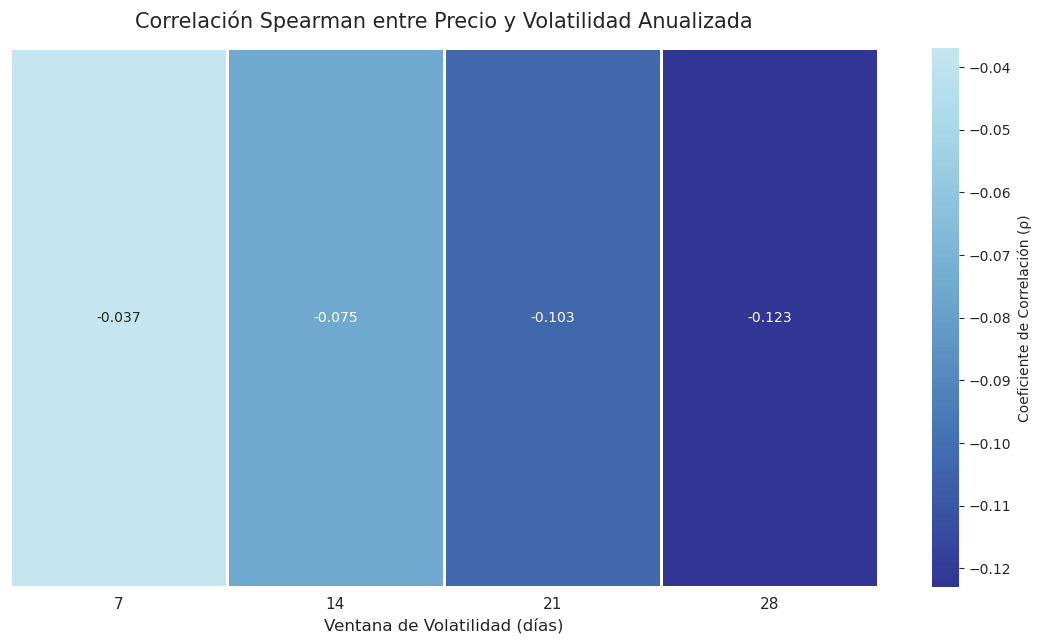

In [29]:
resultados = {}
for col, v in zip(volatilidad_cols, ventanas):
    temporal = databtc[['Precio', col]].dropna()

    r_s, p_s = spearmanr(temporal['Precio'], temporal[col])
    resultados[int(v)] = {   
        "Spearman_r": r_s,
        "Spearman_p": p_s
    }

resultados_df = pd.DataFrame(resultados).T

resultados_df["Spearman_r"] = resultados_df["Spearman_r"].map("{:.3f}".format)
resultados_df["Spearman_p"] = resultados_df["Spearman_p"].map("{:.2e}".format)

heatmap_data = pd.DataFrame({
    "Ventana (días)": resultados_df.index,
    "": resultados_df["Spearman_r"].astype(float)
}).set_index("Ventana (días)").T  

# Heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    cmap="RdYlBu_r",  
    center=0, 
    fmt=".3f", 
    linewidths=1, 
    linecolor="white",
    cbar_kws={'label': 'Coeficiente de Correlación (ρ)'}
)

plt.title("Correlación Spearman entre Precio y Volatilidad Anualizada", fontsize=15, pad=15)
plt.yticks(rotation=0, fontsize=11)
plt.xticks(fontsize=11)
plt.xlabel("Ventana de Volatilidad (días)", fontsize=12)
plt.ylabel("")
plt.show()

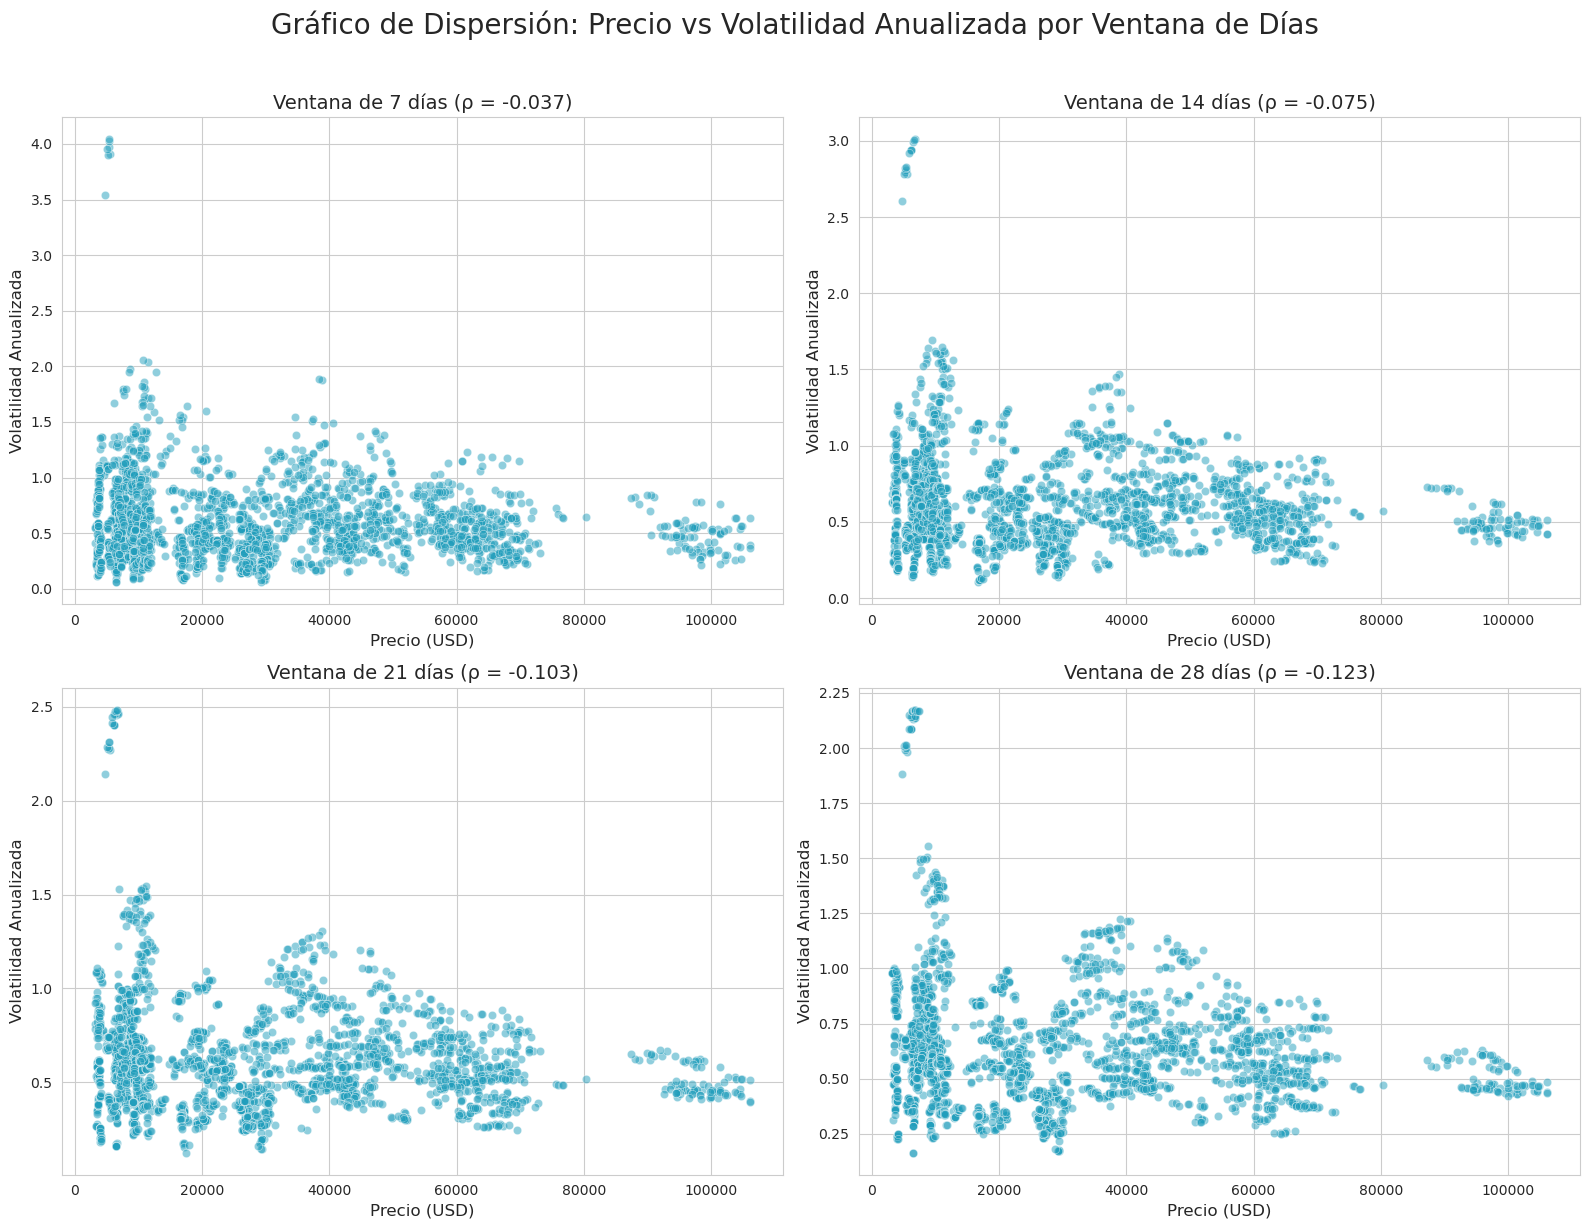

In [30]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

fig.suptitle('Gráfico de Dispersión: Precio vs Volatilidad Anualizada por Ventana de Días', 
             fontsize=20, y=1.02)

for ax, col, ventana in zip(axes.flatten(), volatilidad_cols, ventanas):
    sns.scatterplot(
        x=databtc['Precio'],
        y=databtc[col],
        alpha=0.5,
        ax=ax,
        color="#219ebc"
    )
    
    r_s = resultados[int(ventana)]["Spearman_r"]
    
    ax.set_xlabel('Precio (USD)', fontsize=12)
    ax.set_ylabel('Volatilidad Anualizada', fontsize=12)
    ax.set_title(f'Ventana de {ventana} días (ρ = {r_s:.3f})', fontsize=14)

plt.tight_layout()
plt.show()


Los coeficientes de correlación de Spearman (rho) obtenidos para las ventanas de 7, 14, 21 y 28 días (**-0.031, -0.070, -0.101 y -0.123**, respectivamente) reflejan una relación débil y no significativa entre los precios de cierre y la volatilidad en cada periodo. Este comportamiento coincide con lo observado en los gráficos de dispersión, donde no se evidencia una tendencia clara. Además, el signo negativo de los coeficientes sugiere una relación inversa: a medida que los precios aumentan, la volatilidad tiende a disminuir, aunque este efecto es insignificante.

##### **Correlación de la Volatilidad (por ventanas) con el Valor Absoluto de los Retornos Logarítmicos**

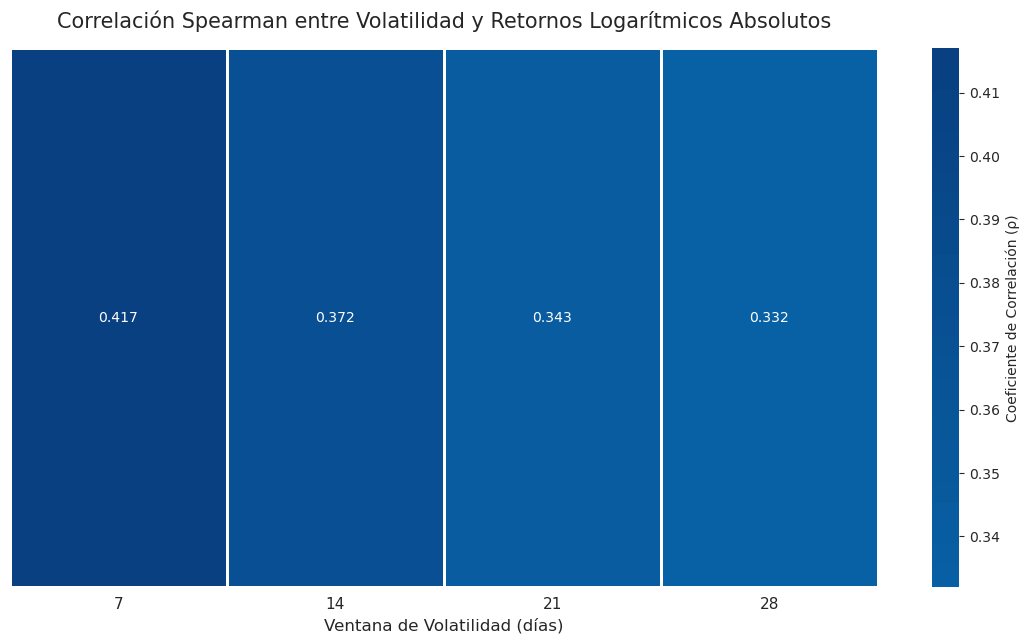

In [31]:
retornosabs = databtc['RetornoLog'].abs()
retornosabs.name = 'AbsRetornoLog'  

resultados = {}

for col, v in zip(volatilidad_cols, ventanas):
    temporal = pd.concat([databtc[col], retornosabs], axis=1).dropna()

    r_s, p_s = spearmanr(temporal['AbsRetornoLog'], temporal[col])
    resultados[int(v)] = {
        "Spearman_r": r_s,
        "Spearman_p": p_s
    }

resultados_df = pd.DataFrame(resultados).T
resultados_df["Spearman_r"] = resultados_df["Spearman_r"].map("{:.3f}".format)
resultados_df["Spearman_p"] = resultados_df["Spearman_p"].map("{:.2e}".format)

heatmap_data = pd.DataFrame({
    "Ventana (días)": resultados_df.index,
    "": resultados_df["Spearman_r"].astype(float)
}).set_index("Ventana (días)").T

plt.figure(figsize=(14, 7))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="GnBu",
    center=0,
    fmt=".3f",
    linewidths=1,
    linecolor="white",
    cbar_kws={'label': 'Coeficiente de Correlación (ρ)'}
)

plt.title("Correlación Spearman entre Volatilidad y Retornos Logarítmicos Absolutos", fontsize=15, pad=15)
plt.yticks(rotation=0, fontsize=11)
plt.xticks(fontsize=11)
plt.xlabel("Ventana de Volatilidad (días)", fontsize=12)
plt.ylabel("")
plt.show()

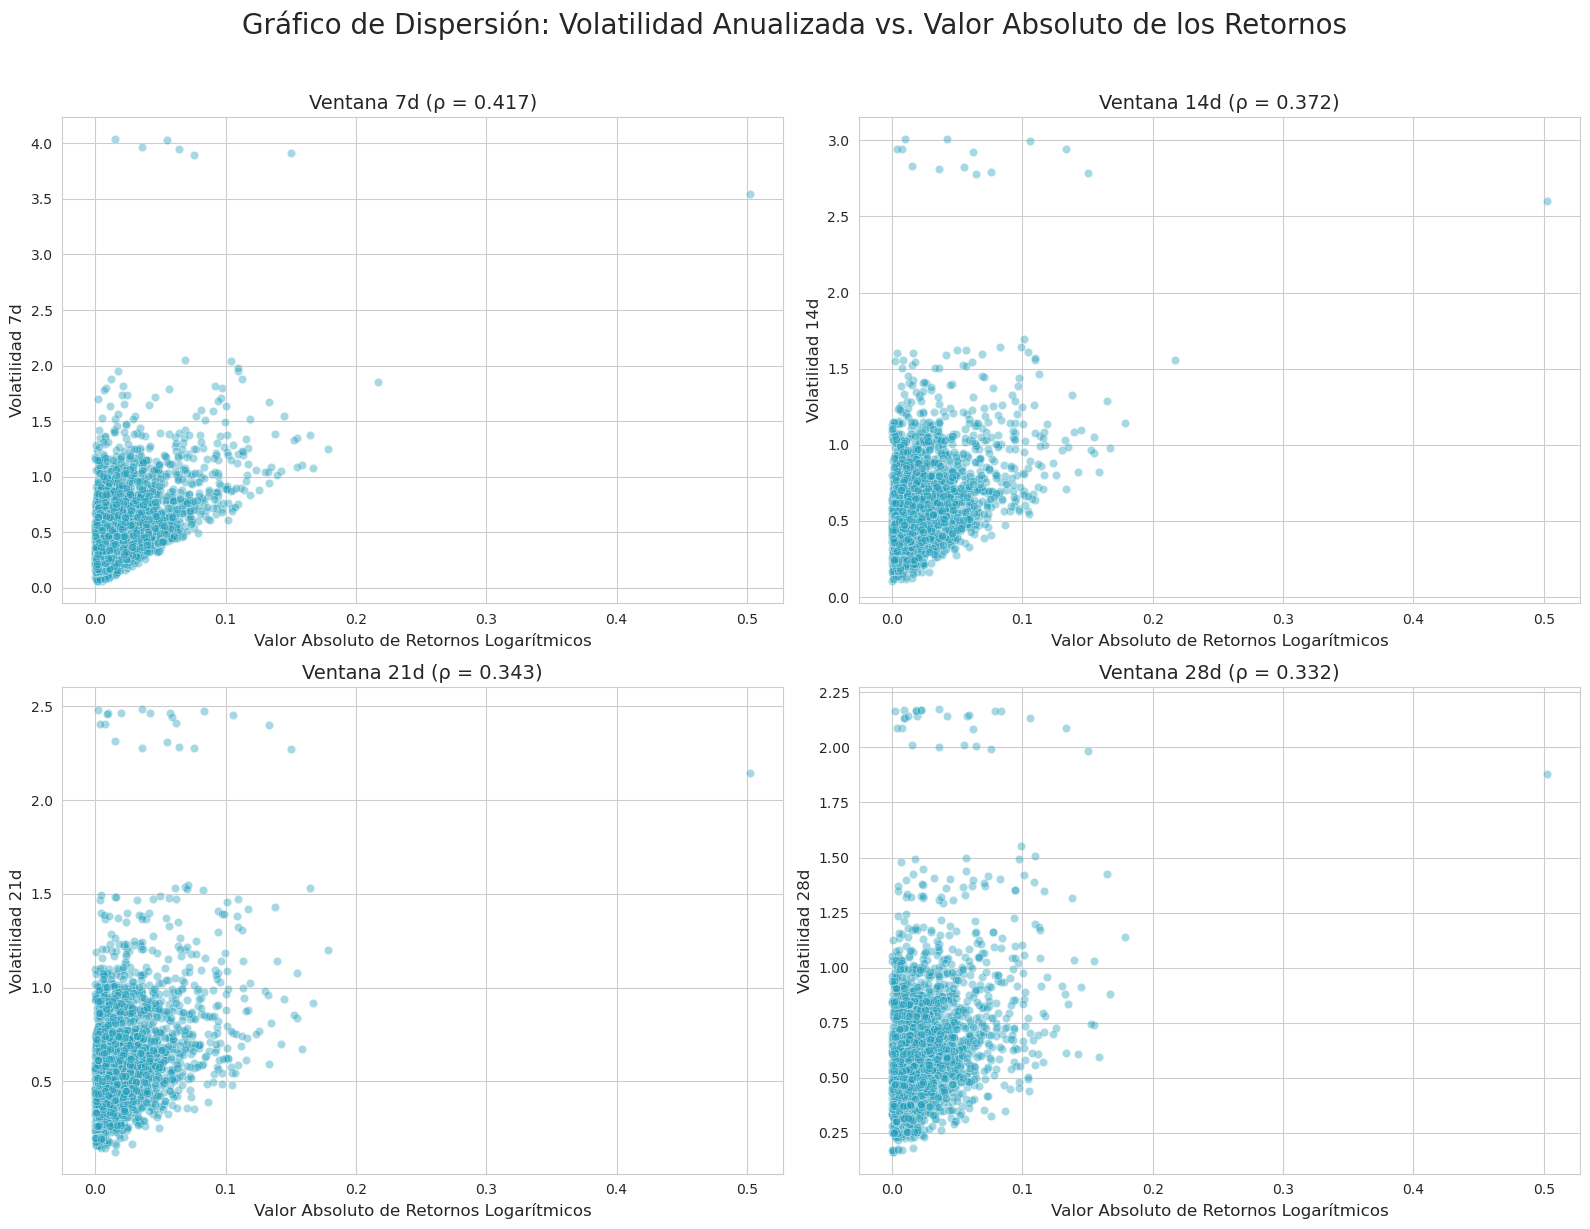

In [32]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

fig.suptitle('Gráfico de Dispersión: Volatilidad Anualizada vs. Valor Absoluto de los Retornos', 
             fontsize=20, y=1.02)

for ax, col in zip(axes.flatten(), volatilidad_cols):
    # Calcular correlación de Spearman
    r_s, p_s = spearmanr(databtc['RetornoLog'].abs(), databtc[col], nan_policy="omit")
    
    sns.scatterplot(x=databtc['RetornoLog'].abs(), y=databtc[col], alpha=0.4, ax=ax, color="#219ebc")
    
    ax.set_title(f'Ventana {col.split("_")[1]} (ρ = {r_s:.3f})', fontsize=14)
    ax.set_xlabel('Valor Absoluto de Retornos Logarítmicos', fontsize=12)
    ax.set_ylabel(f'Volatilidad {col.split("_")[1]}', fontsize=12)

plt.tight_layout()
plt.show()

Los coeficientes de correlación de Spearman (ρ) obtenidos para las ventanas de 7, 14, 21 y 28 días (**0.417, 0.372, 0.343 y 0.332**, respectivamente) indican una relación débil y poco significativa entre la volatilidad y los retornos logarítmicos absolutos en cada periodo. Este comportamiento coincide con lo observado en los gráficos de dispersión, donde no se aprecia una tendencia clara: aunque algunos puntos muestran aumentos simultáneos en ambas variables, no se identifica un patrón consistente.

In [33]:
data = databtc.copy()

## **Base de datos para modelos**

In [34]:
data.dropna(inplace=True)
data

,Precio,RetornoLog,Volatilidad_7d,Volatilidad_14d,Volatilidad_21d,Volatilidad_28d
Fecha,,,,,,
2018-01-29,11251.00,-0.054395,0.690572,1.522041,1.371132,1.367343
2018-01-30,10237.51,-0.094399,1.005329,1.143258,1.410198,1.351515
2018-01-31,10285.10,0.004638,0.895483,1.142321,1.395937,1.348702
2018-02-01,9224.52,-0.108831,1.127962,1.259500,1.383471,1.388793
2018-02-02,8873.03,-0.038849,1.117298,1.223554,1.365130,1.292856
...,...,...,...,...,...,...
2025-02-02,99796.00,-0.024038,0.319643,0.426355,0.448729,0.480990
2025-02-03,94495.21,-0.054579,0.486452,0.504795,0.508193,0.498576
2025-02-04,101367.77,0.070206,0.764874,0.545473,0.581348,0.528412


Luego de realizar todo el preprocesamiento, se construyó una base de datos que incluye variables como la fecha, precio, retornos y las volatilidades por cada ventana. Posteriormente, se eliminaron todas las filas con datos faltantes, las cuales surgieron como consecuencia natural de la generación de rezagos y horizontes de predicción. En total, se descartaron **28** observaciones, equivalentes al **1.07%** del conjunto original.

In [35]:
data.to_csv("../data/datamodelos.csv", index=True)